In [1]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Prepo 2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

# Model
from imblearn.over_sampling import ADASYN
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
feature = pd.read_csv(r'C:\Users\daffa\OneDrive - UGM 365\Keperluan Lomba\ICONIC\Iconic_2024\Dataset\Ekonomi\Credit_card.csv') 
label = pd.read_csv(r'C:\Users\daffa\OneDrive - UGM 365\Keperluan Lomba\ICONIC\Iconic_2024\Dataset\Ekonomi\Credit_card_label.csv')

In [3]:
# Gabungkan data feature dengan label dengan Ind_ID
data = pd.merge(feature, label, on='Ind_ID')
data

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
1544,5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
1545,5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0
1546,5118219,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0


In [4]:
# Menghapus kolom Ind_ID
data = data.drop(columns=['Ind_ID'])

In [5]:
# Ensure 'Years_Employed' is added correctly
data['Years_Employed'] = data['Employed_days'] // 365

# Ensure that Birthday_count is positive
data['Birthday_count'] = data['Birthday_count'].abs()

# Create new features
data['Income_per_Family_Member'] = data['Annual_income'] / data['Family_Members']
data['Children_per_Family_Member'] = data['CHILDREN'] / data['Family_Members']
data['Is_Employed'] = data['Employed_days'] > 0

# Assuming data is your DataFrame and it has a 'label' column for the target variable
X = data.drop(columns='label')
y = data['label']

# Convert y to an integer or categorical type if needed
if y.dtype == 'object':
    y = y.astype('category').cat.codes
elif y.dtype == 'float':
    y = y.astype(int)

# Update the feature lists
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Define the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Set up oversampling with ADASYN
oversampler = ADASYN(random_state=42)

# Create and apply pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Oversampling
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_processed, y_train)

# Get the feature names after one-hot encoding and other preprocessing
feature_names = list(preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)) + \
                list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

# Convert the resampled data into a DataFrame
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_names)

# Convert y_train_resampled into a Series and add it to the DataFrame
y_train_resampled_df = pd.Series(y_train_resampled, name='label')

# Concatenate the features and target into a single DataFrame
resampled_df = pd.concat([X_train_resampled_df, y_train_resampled_df], axis=1)

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}


Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.4844 - loss: 1.7227 - val_accuracy: 0.2638 - val_loss: 1.5010 - learning_rate: 0.0010
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5310 - loss: 1.5854 - val_accuracy: 0.1835 - val_loss: 1.5748 - learning_rate: 0.0010
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5770 - loss: 1.4804 - val_accuracy: 0.2706 - val_loss: 1.6081 - learning_rate: 0.0010
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5588 - loss: 1.5036 - val_accuracy: 0.3096 - val_loss: 1.6133 - learning_rate: 0.0010
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6259 - loss: 1.4233 - val_accuracy: 0.2569 - val_loss: 1.6215 - learning_rate: 0.0010
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6208 - loss: 1.4007 - val_accuracy: 0.2248 - val_loss: 1.6682 - learning_rate: 0.0010
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6361 - loss: 1.3729 -

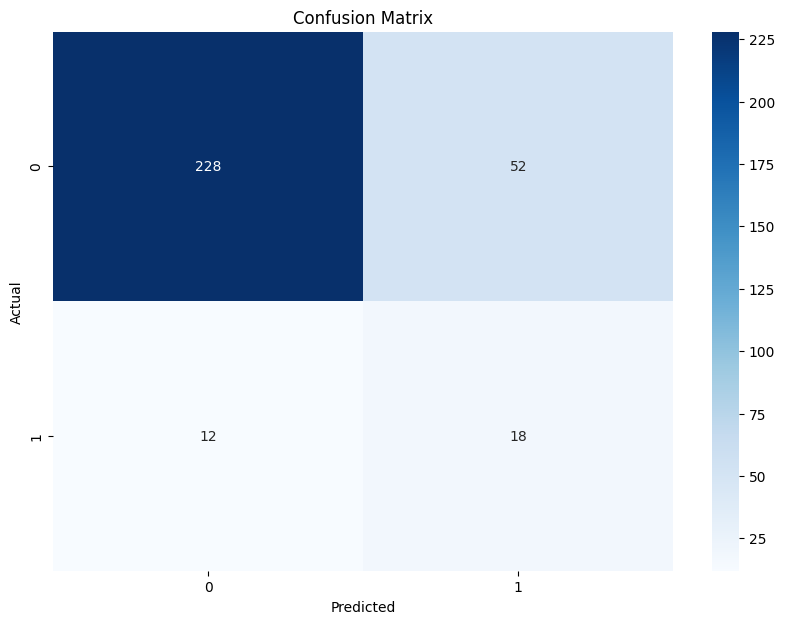

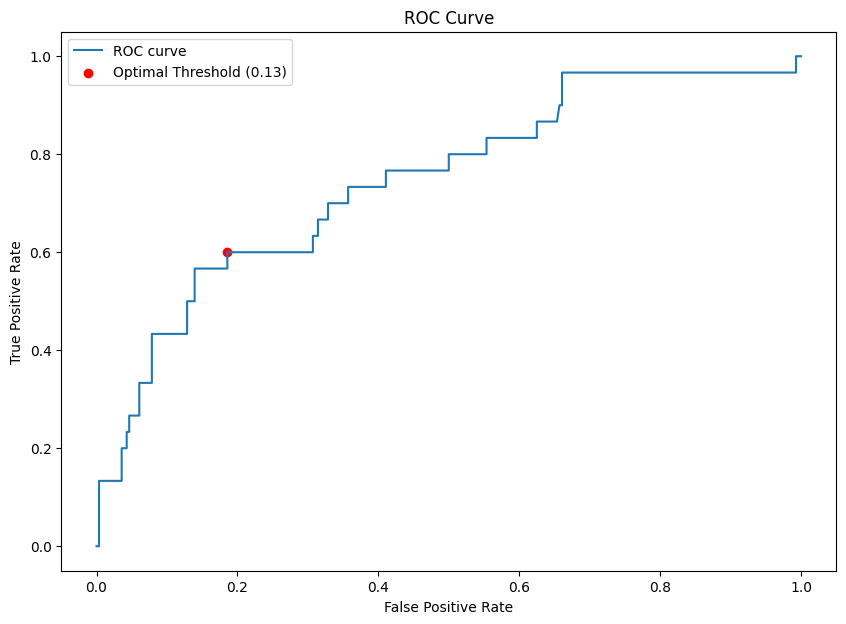

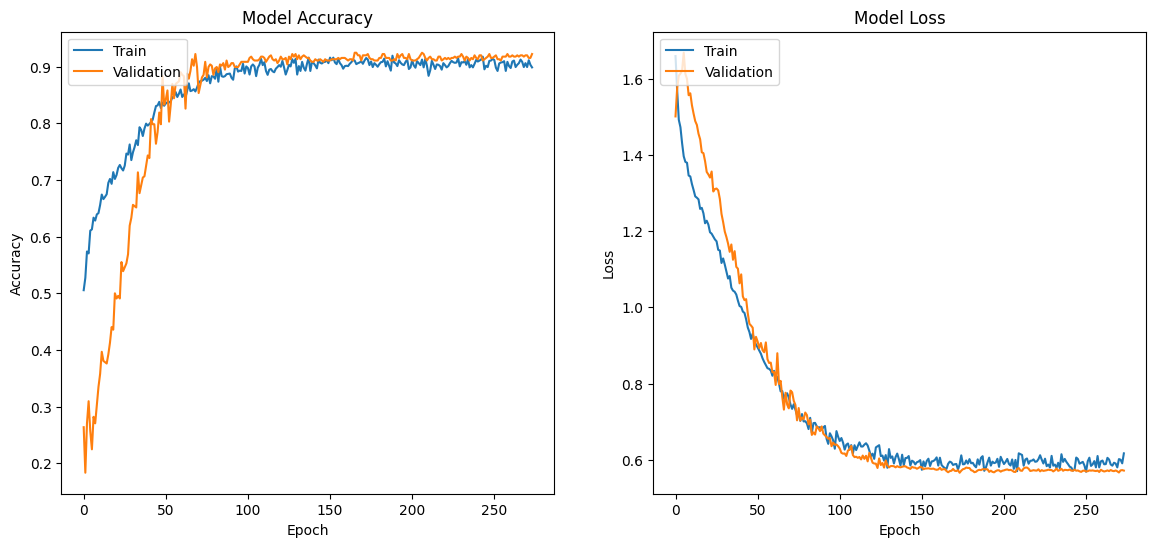

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the neural network model with optimizations
model = Sequential([
    Dense(512, input_dim=X_train_resampled.shape[1], kernel_regularizer=l2(0.001)),  # L2 regularization
    BatchNormalization(),  # Batch Normalization
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(128, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer and learning rate schedule
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with class weights and callbacks
history = model.fit(
    X_train_resampled, y_train_resampled, 
    epochs=300, batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
y_pred_probs = model.predict(X_test_processed)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate specificity (1 - false positive rate)
specificity = 1 - fpr

# Calculate geometric mean for each threshold
gmeans = np.sqrt(tpr * specificity)

# Find the optimal threshold
optimal_idx = np.argmax(gmeans)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold based on Geometric Mean: {optimal_threshold}")

# Make predictions based on the optimal threshold
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Evaluate the new predictions
print("Classification Report:")
print(classification_report(y_test, y_pred,digits=3))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the ROC curve with the optimal point marked
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


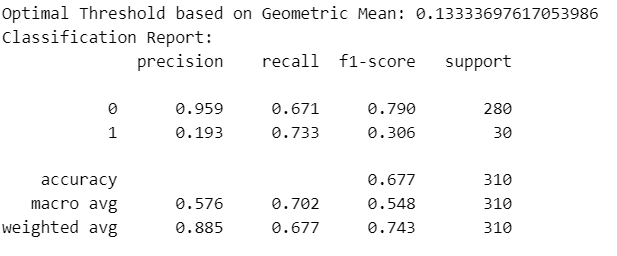

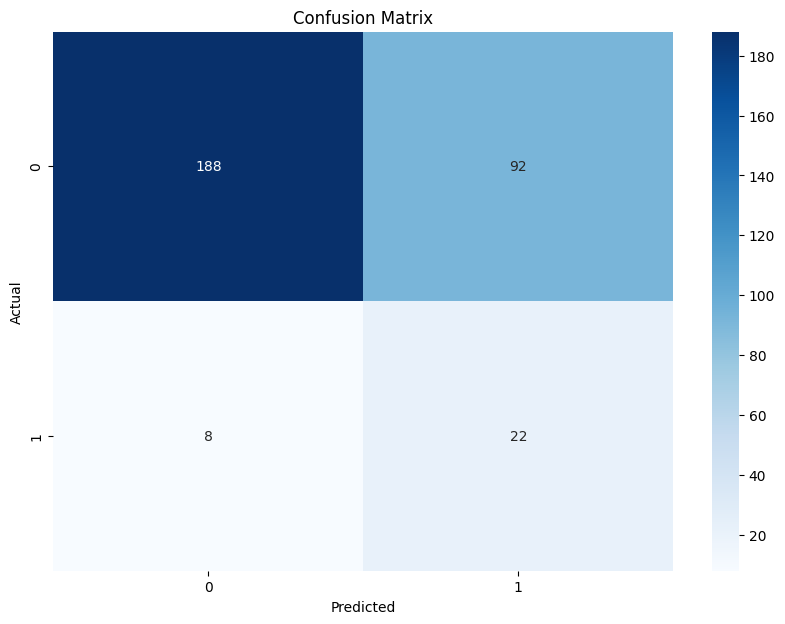
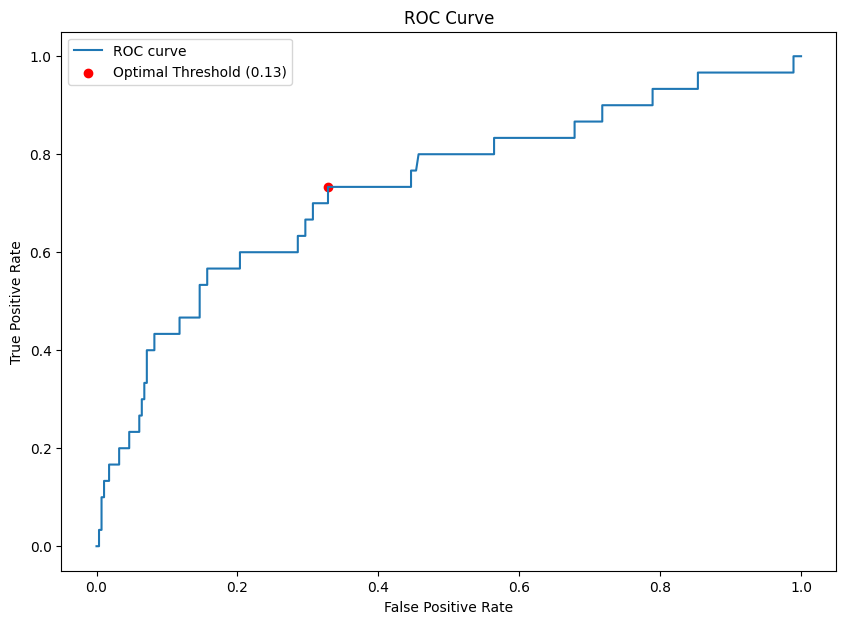

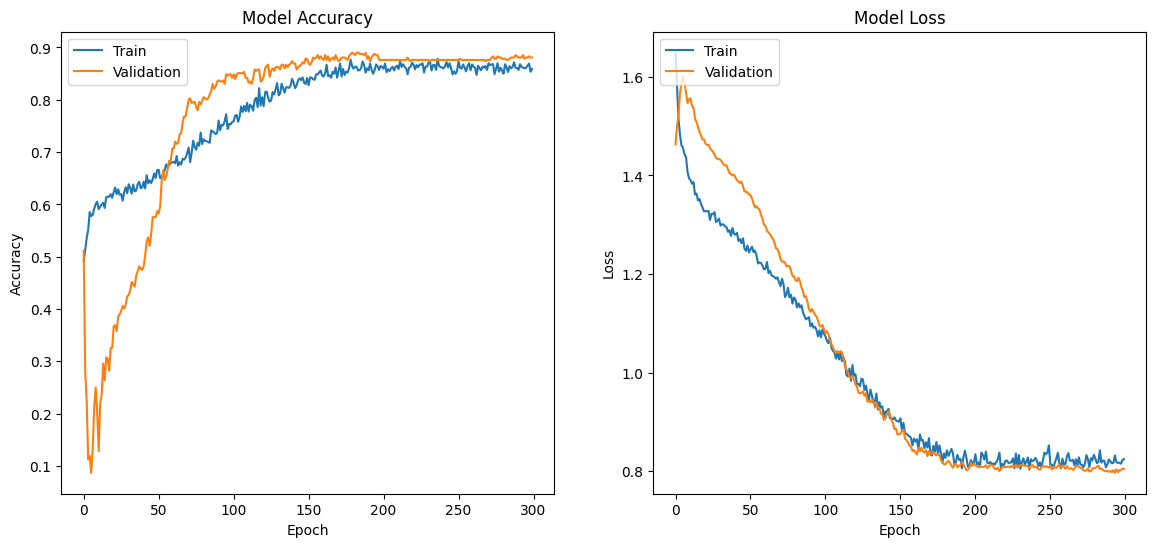